# HW3 Practical: Comparing Generative Paradigms on CIFAR-10


Welcome! This notebook provides the training and evaluation pipeline for the four generative models you will build in `models/`.

- Run the setup cells to install dependencies and load CIFAR-10.
- Complete the TODOs in the Python modules, verify with Gradescope autograder, then return here to train and evaluate models.
- Follow the prompts in each section to log results and save artefacts (sample image grids, metrics, and plots) for inclusion in your PDF report.


In [ ]:
# Install lightweight dependencies (safe to re-run)
%pip install --quiet torch-fidelity tqdm


In [ ]:
import os
from google.colab import drive
# drive.mount('/content/drive')
os.getcwd()
# os.chdir('/content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn')


'/content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn'

In [ ]:
import math
import time
import json
from pathlib import Path
from collections import defaultdict

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from tqdm.auto import tqdm

from cifar10 import load_cifar10
from models.gan import DCGAN
from models.vae import ConvVAE
from models.pixelcnn import PixelCNN
from models.ddpm import DenoiseUNet

from torch_fidelity import calculate_metrics

In [ ]:
# Global configuration
PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True, parents=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

BATCH_SIZE = 128
NUM_WORKERS = 0
IMAGE_SIZE = 32
NUM_CLASSES = 10

print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_name}")
print(f"Project root: {PROJECT_ROOT}")


Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Project root: /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn


### Experiment presets

The dictionaries below define the baseline ("small") and scaled ("medium") configurations used in the assignment. Baselines train for 30 epochs, and the scaled variants run for 40 epochs so you can contrast added capacity with extra compute. Feel free to explore other values.


In [ ]:
EXPERIMENT_CONFIGS = {
    "dcgan": {
        "small": {"base_channels": 64, "latent_dim": 128, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "latent_dim": 128, "epochs": 40, "lr": 2e-4},
    },
    "vae": {
        "small": {"base_channels": 64, "latent_dim": 128, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "latent_dim": 192, "epochs": 40, "lr": 2e-4},
    },
    "pixelcnn": {
        "small": {"hidden_channels": 64, "residual_layers": 5, "epochs": 30, "lr": 3e-4},
        "medium": {"hidden_channels": 96, "residual_layers": 7, "epochs": 40, "lr": 3e-4},
    },
    "ddpm": {
        "small": {"base_channels": 64, "time_channels": 256, "timesteps": 1000, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "time_channels": 256, "timesteps": 750, "epochs": 40, "lr": 2e-4},
    },
}

EXPERIMENT_CONFIGS


{'dcgan': {'small': {'base_channels': 64,
   'latent_dim': 128,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'latent_dim': 128,
   'epochs': 40,
   'lr': 0.0002}},
 'vae': {'small': {'base_channels': 64,
   'latent_dim': 128,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'latent_dim': 192,
   'epochs': 40,
   'lr': 0.0002}},
 'pixelcnn': {'small': {'hidden_channels': 64,
   'residual_layers': 5,
   'epochs': 30,
   'lr': 0.0003},
  'medium': {'hidden_channels': 96,
   'residual_layers': 7,
   'epochs': 40,
   'lr': 0.0003}},
 'ddpm': {'small': {'base_channels': 64,
   'time_channels': 256,
   'timesteps': 1000,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'time_channels': 256,
   'timesteps': 750,
   'epochs': 40,
   'lr': 0.0002}}}

In [ ]:
THROUGHPUT_SAMPLES = {
    "dcgan": 1024,
    "vae": 1024,
    "pixelcnn": 1024,  # autoregressive sampling is slow; document your actual sample count if you change this
    "ddpm": 1024,
}

THROUGHPUT_SAMPLES


{'dcgan': 1024, 'vae': 1024, 'pixelcnn': 1024, 'ddpm': 1024}

## Data loading


In [ ]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=True,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=False,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, val_loader


set_seed(SEED)
train_loader, val_loader = get_dataloaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 391, Validation batches: 79


In [ ]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=True,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=False,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, val_loader


set_seed(SEED)
train_loader, val_loader = get_dataloaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 391, Validation batches: 79


## Utility functions


In [ ]:
def to_device(batch, device=DEVICE):
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}


def images_to_uint8(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor.detach().cpu().clamp(0.0, 1.0)
    tensor = (tensor * 255.0).round().to(torch.uint8)
    return tensor.permute(0, 2, 3, 1).numpy()


def save_image_grid(images: torch.Tensor, path: Path, nrow: int = 8):
    path.parent.mkdir(parents=True, exist_ok=True)
    grid = make_grid(images.detach().cpu(), nrow=nrow, padding=2)
    save_image(grid, str(path))
    return grid


def gather_real_images(loader: DataLoader, max_samples: int = 2048) -> torch.Tensor:
    batches = []
    total = 0
    for batch in loader:
        imgs = batch["images"]
        batches.append(imgs)
        total += imgs.size(0)
        if total >= max_samples:
            break
    return torch.cat(batches, dim=0)[:max_samples]


def compute_kid_score(real_images: torch.Tensor, fake_images: torch.Tensor) -> float:
    real_np = images_to_uint8(real_images)
    fake_np = images_to_uint8(fake_images)

    from torch.utils.data import Dataset

    class _ArrayDataset(Dataset):
        def __init__(self, array: np.ndarray):
            self.array = array

        def __len__(self) -> int:
            return self.array.shape[0]

        def __getitem__(self, idx: int):
            arr = self.array[idx]
            tensor = torch.from_numpy(arr).permute(2, 0, 1).contiguous()
            return tensor

    metrics = calculate_metrics(
        input1=_ArrayDataset(fake_np),
        input2=_ArrayDataset(real_np),
        kid=True,
        fid=False,
        verbose=False,
    )
    kid_key = "kernel_inception_distance_mean"
    if kid_key not in metrics:
        kid_key = "kid_mean"
    kid_value = metrics.get(kid_key)
    if kid_value is None:
        raise KeyError(f"KID metric missing expected keys: {list(metrics.keys())}")
    return float(kid_value)


def measure_sampling_throughput(sample_fn, num_images: int = 1024, device=DEVICE):
    torch.cuda.empty_cache()
    torch.cuda.synchronize() if device.type == "cuda" else None
    start = time.perf_counter()
    samples = sample_fn(num_images=num_images, device=device)
    torch.cuda.synchronize() if device.type == "cuda" else None
    elapsed = time.perf_counter() - start
    throughput = num_images / elapsed
    return samples, elapsed, throughput


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def save_loss_history(history, name):
    out_path = ARTIFACT_DIR / f"{name}_history.json"
    with out_path.open("w") as f:
        json.dump(history, f, indent=2)
    print(f"Saved history to {out_path}")



In [ ]:
real_subset = gather_real_images(val_loader, max_samples=2048)
real_subset_device = real_subset.to(DEVICE)
print(f"Real subset cached: {real_subset.shape} (device copy: {real_subset_device.shape})")



Real subset cached: torch.Size([2048, 3, 32, 32]) (device copy: torch.Size([2048, 3, 32, 32]))


## Training loops


In [ ]:
def _init_history():
    return defaultdict(list)

def train_dcgan(model: DCGAN, dataloader: DataLoader, optimizer_g, optimizer_d, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[DCGAN] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)

            model.zero_grad(set_to_none=True)
            optimizer_d.zero_grad(set_to_none=True)
            out_d = model({"images": images})
            loss_d = out_d["discriminator_loss"]
            loss_d.backward()
            optimizer_d.step()

            model.zero_grad(set_to_none=True)
            optimizer_g.zero_grad(set_to_none=True)
            out_g = model({"images": images})
            loss_g = out_g["generator_loss"]
            loss_g.backward()
            optimizer_g.step()

            history["d_loss"].append(loss_d.item())
            history["g_loss"].append(loss_g.item())
            progress.set_postfix({"d": loss_d.item(), "g": loss_g.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_vae(model: ConvVAE, dataloader: DataLoader, optimizer, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[VAE] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            history["kl"].append(out["kl"].mean().item())
            history["recon"].append(out["reconstruction_loss"].mean().item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_pixelcnn(model: PixelCNN, dataloader: DataLoader, optimizer, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[PixelCNN] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_ddpm(model: DenoiseUNet, dataloader: DataLoader, optimizer, epochs: int = 1, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[DDPM] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history



## Sampling & evaluation helper functions


In [ ]:
@torch.no_grad()
def sample_dcgan(model: DCGAN, num_samples: int = 64, device=DEVICE, batch_size: int = 64):
    model.eval()
    model.to(device)
    samples = []
    for start in range(0, num_samples, batch_size):
        n = min(batch_size, num_samples - start)
        z = torch.randn(n, model.latent_dim, device=device)
        fake = model.sample(z) # sample from the model
        samples.append(fake.detach().cpu())
    return torch.cat(samples, dim=0)


@torch.no_grad()
def sample_vae(model: ConvVAE, num_samples: int = 64, device=DEVICE, batch_size: int = 64):
    model.eval()
    model.to(device)
    samples = []
    for start in range(0, num_samples, batch_size):
        n = min(batch_size, num_samples - start)
        z = torch.randn(n, model.latent_dim, device=device)
        mean, logvar = model.decode(z) # decode the latent codes using the model
        std = torch.exp(0.5 * logvar)
        draw = model.reparameterize(mean, logvar) # sample from the distribution
        samples.append(draw.detach().cpu())
    return torch.cat(samples, dim=0).clamp(0.0, 1.0)


@torch.no_grad()
def sample_pixelcnn(model: PixelCNN, num_samples: int = 16, device=DEVICE, image_size: int = IMAGE_SIZE):
    model.eval()
    model.to(device)
    bins = model.bins
    samples = torch.zeros(num_samples, model.image_channels, image_size, image_size, device=device)
    for row in range(image_size):
        for col in range(image_size):
            logits = model.net(samples) # get the logits from the model
            logits = logits.view(num_samples, model.image_channels, bins, image_size, image_size)
            logits_last = logits[:, :, :, row, col]
            probs = torch.softmax(logits_last, dim=2) # Softmax the logits to get the probability of each bin
            cat = torch.distributions.Categorical(probs=probs)
            pixel = cat.sample()
            pixel = pixel.float() / (bins - 1)
            samples[:, :, row, col] = pixel
    return samples.detach().cpu().clamp(0.0, 1.0)


@torch.no_grad()
def _ddpm_predict_noise(model: DenoiseUNet, xt: torch.Tensor, t: torch.Tensor):
    time_emb = model.time_embedding(t)
    h0 = model.model["init"](xt)
    skip0, h1 = model.model["down0"](h0, time_emb)
    skip1, h2 = model.model["down1"](h1, time_emb)
    skip2, h3 = model.model["down2"](h2, time_emb)
    h_mid = model.model["mid"](h3, time_emb)
    h = model.model["up2"](h_mid, skip2, time_emb)
    h = model.model["up1"](h, skip1, time_emb)
    h = model.model["up0"](h, skip0, time_emb)
    pred_noise = model.model["out"](h)
    return pred_noise


@torch.no_grad()
def sample_ddpm(model: DenoiseUNet, num_samples: int = 64, device=DEVICE, timesteps: int = None):
    model.eval()
    model.to(device)
    T = timesteps if timesteps is not None else model.timesteps
    betas = model.betas.to(device)
    alphas = 1.0 - betas
    alphas_cumprod = model.alphas_cumprod.to(device)
    alphas_cumprod_prev = torch.cat([torch.ones(1, device=device), alphas_cumprod[:-1]])
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_one_minus_cumprod = torch.sqrt(1.0 - alphas_cumprod)

    xt = torch.randn(num_samples, model.image_channels, IMAGE_SIZE, IMAGE_SIZE, device=device)
    for step in reversed(range(T)):
        t = torch.full((num_samples,), step, device=device, dtype=torch.long)
        pred_noise = _ddpm_predict_noise(model, xt, t) # predict the noise from the model
        beta_t = betas[step]
        sqrt_recip_alpha_t = sqrt_recip_alphas[step]
        sqrt_one_minus_cumprod_t = sqrt_one_minus_cumprod[step]
        model_mean = sqrt_recip_alpha_t * (xt - beta_t / sqrt_one_minus_cumprod_t * pred_noise)
        if step > 0:
            variance = beta_t * (1.0 - alphas_cumprod_prev[step]) / (1.0 - alphas_cumprod[step])
            noise = torch.randn_like(xt)
            xt = model_mean + torch.sqrt(variance) * noise # update the image
        else:
            xt = model_mean
    return xt.detach().cpu().clamp(-1.0, 1.0)



## Experiment tracking utilities


In [ ]:
experiment_log = {}


def record_metrics(model_name: str, variant: str, metrics: dict):
    experiment_log.setdefault(model_name, {})[variant] = metrics


def show_metrics(model_name: str = None):
    if model_name is None:
        for name in experiment_log:
            show_metrics(name)
        return
    print(f"=== {model_name} ===")
    entries = experiment_log.get(model_name, {})
    for variant, metrics in entries.items():
        print(f"  [{variant}]")
        for key, value in metrics.items():
            print(f"    {key}: {value}")
    if not entries:
        print("  (no entries yet)")


## DCGAN (adversarial generation)

Fill in the TODOs inside `models/gan.py` before running this section. The cells below:

1. Instantiate the model and optimizers.
2. Train for the baseline configuration.
3. Generate sample grids, measure KID, and record sampling throughput.
4. Repeat with the medium-scale variant


In [ ]:
dcgan_cfg = EXPERIMENT_CONFIGS["dcgan"]["small"]
dcgan = DCGAN(
    image_channels=3,
    latent_dim=dcgan_cfg["latent_dim"],
    base_channels=dcgan_cfg["base_channels"],
)
optim_g = torch.optim.Adam(dcgan.generator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
optim_d = torch.optim.Adam(dcgan.discriminator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
print(f"Baseline DCGAN parameters: {count_parameters(dcgan):,}")


Baseline DCGAN parameters: 1,846,980


In [ ]:
DCGAN_EPOCHS = dcgan_cfg["epochs"]

dcgan_history = train_dcgan(dcgan, train_loader, optimizer_g=optim_g, optimizer_d=optim_d, epochs=DCGAN_EPOCHS)
dcgan_epoch_times = dcgan_history["epoch_time"]  # populate this inside your implementation
dcgan_train_time = sum(dcgan_epoch_times)
print(f"Finished DCGAN training: {len(dcgan_history['d_loss'])} steps")
print(f"DCGAN training time per epoch (s): {[round(t, 2) for t in dcgan_epoch_times]}")


[DCGAN] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished DCGAN training: 11730 steps
DCGAN training time per epoch (s): [6.26, 4.86, 4.87, 4.88, 4.95, 4.9, 4.88, 4.91, 4.85, 4.92, 4.9, 4.89, 4.92, 5.02, 5.17, 4.99, 4.93, 4.92, 4.91, 5.1, 4.92, 5.12, 5.09, 4.91, 4.96, 4.91, 4.91, 4.91, 4.88, 5.02]


In [ ]:
save_loss_history(dcgan_history, "dcgan_baseline_history")

Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/dcgan_baseline_history_history.json


In [ ]:
# TODO: run once `sample_dcgan` is implemented.
# Evaluation: sampling, KID, throughput
samples_36 = sample_dcgan(dcgan, num_samples=36, device=DEVICE)
samples_36_vis = (samples_36 + 1.0) / 2.0  # map from [-1, 1] to [0, 1]
save_image_grid(samples_36_vis, ARTIFACT_DIR / "dcgan_samples_baseline_6x6.png", nrow=6)

sample_budget = THROUGHPUT_SAMPLES["dcgan"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_dcgan(dcgan, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DCGAN",
    "baseline",
    {
        "epochs": DCGAN_EPOCHS,
        "params": count_parameters(dcgan),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": dcgan_train_time,
        "train_time_per_epoch_s": dcgan_train_time / DCGAN_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")


KID (x10^3): 0.059
Sampling time for 1024 images: 0.02 s (throughput 49664.1 img/s)


> **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("DCGAN", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [ ]:
# DCGAN medium 30 epochs
dcgan_cfg = EXPERIMENT_CONFIGS["dcgan"]["medium"]
dcgan_medium_30 = DCGAN(
    image_channels=3,
    latent_dim=dcgan_cfg["latent_dim"],
    base_channels=dcgan_cfg["base_channels"],
)
optim_g = torch.optim.Adam(dcgan_medium_30.generator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
optim_d = torch.optim.Adam(dcgan_medium_30.discriminator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
print(f"DCGAN medium 30 parameters: {count_parameters(dcgan_medium_30):,}")

DCGAN_EPOCHS = 30

dcgan_history = train_dcgan(dcgan_medium_30, train_loader, optimizer_g=optim_g, optimizer_d=optim_d, epochs=DCGAN_EPOCHS)
dcgan_epoch_times = dcgan_history["epoch_time"]  # populate this inside your implementation
dcgan_train_time = sum(dcgan_epoch_times)
print(f"Finished DCGAN medium 30 training: {len(dcgan_history['d_loss'])} steps")
print(f"DCGAN medium 30 training time per epoch (s): {[round(t, 2) for t in dcgan_epoch_times]}")
save_loss_history(dcgan_history, "dcgan_scaled-30ep_history")

# TODO: run once `sample_dcgan` is implemented.
# Evaluation: sampling, KID, throughput
samples_64 = sample_dcgan(dcgan_medium_30, num_samples=64, device=DEVICE)
samples_64_vis = (samples_64 + 1.0) / 2.0  # map from [-1, 1] to [0, 1]
save_image_grid(samples_64_vis, ARTIFACT_DIR / "dcgan_samples_medium_30.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["dcgan"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_dcgan(dcgan_medium_30, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DCGAN",
    "scaled-30ep",
    {
        "epochs": DCGAN_EPOCHS,
        "params": count_parameters(dcgan_medium_30),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": dcgan_train_time,
        "train_time_per_epoch_s": dcgan_train_time / DCGAN_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")



DCGAN medium 30 parameters: 3,753,508


[DCGAN] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished DCGAN medium 30 training: 11730 steps
DCGAN medium 30 training time per epoch (s): [5.15, 5.13, 5.05, 5.18, 5.22, 5.11, 5.15, 5.13, 5.14, 5.28, 5.34, 5.2, 5.07, 5.13, 5.05, 5.08, 5.08, 5.07, 5.43, 5.15, 5.16, 5.12, 5.13, 5.36, 5.29, 5.39, 5.13, 5.17, 5.21, 5.22]
Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/dcgan_scaled-30ep_history_history.json
KID (x10^3): 0.056
Sampling time for 1024 images: 0.02 s (throughput 53438.9 img/s)


In [ ]:
# DCGAN medium 40 epochs
dcgan_cfg = EXPERIMENT_CONFIGS["dcgan"]["medium"]
dcgan_medium_40 = DCGAN(
    image_channels=3,
    latent_dim=dcgan_cfg["latent_dim"],
    base_channels=dcgan_cfg["base_channels"],
)
optim_g = torch.optim.Adam(dcgan_medium_40.generator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
optim_d = torch.optim.Adam(dcgan_medium_40.discriminator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
print(f"DCGAN medium 40 parameters: {count_parameters(dcgan_medium_40):,}")

DCGAN_EPOCHS = 40

dcgan_history = train_dcgan(dcgan_medium_40, train_loader, optimizer_g=optim_g, optimizer_d=optim_d, epochs=DCGAN_EPOCHS)
dcgan_epoch_times = dcgan_history["epoch_time"]  # populate this inside your implementation
dcgan_train_time = sum(dcgan_epoch_times)
print(f"Finished DCGAN medium 40 training: {len(dcgan_history['d_loss'])} steps")
print(f"DCGAN medium 40 training time per epoch (s): {[round(t, 2) for t in dcgan_epoch_times]}")
save_loss_history(dcgan_history, "dcgan_scaled-40ep_history")

# TODO: run once `sample_dcgan` is implemented.
# Evaluation: sampling, KID, throughput
samples_64 = sample_dcgan(dcgan_medium_40, num_samples=64, device=DEVICE)
samples_64_vis = (samples_64 + 1.0) / 2.0  # map from [-1, 1] to [0, 1]
save_image_grid(samples_64_vis, ARTIFACT_DIR / "dcgan_samples_medium_40.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["dcgan"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_dcgan(dcgan_medium_40, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DCGAN",
    "scaled-40ep",
    {
        "epochs": DCGAN_EPOCHS,
        "params": count_parameters(dcgan_medium_40),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": dcgan_train_time,
        "train_time_per_epoch_s": dcgan_train_time / DCGAN_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")



DCGAN medium 40 parameters: 3,753,508


[DCGAN] Epoch 1/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 2/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 3/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 4/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 5/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 6/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 7/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 8/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 9/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 10/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 11/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 12/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 13/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 14/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 15/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 16/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 17/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 18/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 19/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 20/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 21/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 22/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 23/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 24/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 25/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 26/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 27/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 28/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 29/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 30/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 31/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 32/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 33/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 34/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 35/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 36/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 37/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 38/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 39/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 40/40:   0%|          | 0/391 [00:00<?, ?it/s]

Finished DCGAN medium 40 training: 15640 steps
DCGAN medium 40 training time per epoch (s): [5.22, 5.37, 5.31, 5.16, 5.21, 5.16, 5.22, 5.1, 5.18, 5.11, 5.15, 5.22, 5.18, 5.21, 5.12, 5.19, 5.16, 5.07, 5.14, 5.04, 5.11, 5.03, 5.07, 5.15, 5.09, 5.14, 5.07, 5.09, 5.11, 5.04, 5.12, 5.05, 5.12, 5.12, 5.13, 5.13, 5.06, 5.14, 5.08, 5.08]
Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/dcgan_scaled-40ep_history_history.json
KID (x10^3): 0.044
Sampling time for 1024 images: 0.02 s (throughput 54595.1 img/s)


## Convolutional VAE (latent variable model)

Make sure the loss components in `models/vae.py` are implemented before training.


In [ ]:
vae_cfg = EXPERIMENT_CONFIGS["vae"]["small"]
vae = ConvVAE(
    image_channels=3,
    latent_dim=vae_cfg["latent_dim"],
    base_channels=vae_cfg["base_channels"],
)
optim_vae = torch.optim.Adam(vae.parameters(), lr=vae_cfg["lr"])
print(f"Baseline VAE parameters: {count_parameters(vae):,}")


Baseline VAE parameters: 3,518,214


In [ ]:
VAE_EPOCHS = vae_cfg["epochs"]

vae_history = train_vae(vae, train_loader, optimizer=optim_vae, epochs=VAE_EPOCHS)
vae_epoch_times = vae_history["epoch_time"]  # populate this inside your implementation
vae_train_time = sum(vae_epoch_times)
print(f"Finished VAE training: {len(vae_history['loss'])} steps")
print(f"VAE training time per epoch (s): {[round(t, 2) for t in vae_epoch_times]}")


[VAE] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished VAE training: 11730 steps
VAE training time per epoch (s): [3.44, 3.1, 3.23, 3.14, 3.11, 3.39, 3.39, 3.24, 3.25, 3.33, 3.27, 3.14, 3.13, 3.2, 3.16, 3.1, 3.13, 3.26, 3.16, 3.13, 3.12, 3.34, 3.12, 3.14, 3.14, 3.27, 3.13, 3.15, 3.17, 3.32]


In [ ]:
save_loss_history(vae_history, "vae_baseline_history")

Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/vae_baseline_history.json


In [ ]:
def evaluate_vae_elbo(model: ConvVAE, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = total_recon = total_kl = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += out["loss"].item() * batch_size
            total_recon += out["reconstruction_loss"].mean().item() * batch_size
            total_kl += out["kl"].mean().item() * batch_size
    return {
        "loss": total_loss / total_examples,
        "reconstruction": total_recon / total_examples,
        "kl": total_kl / total_examples,
    }


# TODO: once `sample_vae' are implemented, run the evaluation below.

vae_elbo = evaluate_vae_elbo(vae, val_loader)
vae_samples_36 = sample_vae(vae, num_samples=36, device=DEVICE)
save_image_grid(vae_samples_36, ARTIFACT_DIR / "vae_samples_baseline_6x6.png", nrow=6)

sample_budget = THROUGHPUT_SAMPLES["vae"]
vae_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_vae(vae, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:vae_samples_large.size(0)].cpu(), vae_samples_large.cpu())
record_metrics(
    "VAE",
    "baseline",
    {
        "epochs": VAE_EPOCHS,
        "params": count_parameters(vae),
        "kid": kid,
        "nll": vae_elbo["loss"],
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": vae_train_time,
        "train_time_per_epoch_s": vae_train_time / VAE_EPOCHS,
    },
)

print(f"Validation ELBO: {vae_elbo['loss']:.4f} (recon {vae_elbo['reconstruction']:.4f}, KL {vae_elbo['kl']:.4f})")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {vae_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")



Validation ELBO: -3560.7932 (recon -3795.2261, KL 234.4329)
KID (x10^3): 0.289
Sampling time for 1024 images: 0.03 s (throughput 34186.4 img/s)


> **Scaling experiment:** Retrain the medium-scale configuration and log metrics after 30 and 40 epochs (e.g. `record_metrics("VAE", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [ ]:
# VAE medium 30 epochs

vae_cfg = EXPERIMENT_CONFIGS["vae"]["medium"]
vae_medium_30 = ConvVAE(
    image_channels=3,
    latent_dim=vae_cfg["latent_dim"],
    base_channels=vae_cfg["base_channels"],
)
optim_vae = torch.optim.Adam(vae_medium_30.parameters(), lr=vae_cfg["lr"])
print(f"VAE medium30 parameters: {count_parameters(vae_medium_30):,}")

VAE_EPOCHS = 30

vae_history = train_vae(vae_medium_30, train_loader, optimizer=optim_vae, epochs=VAE_EPOCHS)
vae_epoch_times = vae_history["epoch_time"]  # populate this inside your implementation
vae_train_time = sum(vae_epoch_times)
print(f"Finished VAE medium30 training: {len(vae_history['loss'])} steps")
print(f"VAE medium30 training time per epoch (s): {[round(t, 2) for t in vae_epoch_times]}")
save_loss_history(vae_history, "vae_scaled-30ep_history")

# TODO: once `sample_vae' are implemented, run the evaluation below.

vae_elbo = evaluate_vae_elbo(vae_medium_30, val_loader)
vae_samples = sample_vae(vae_medium_30, num_samples=64, device=DEVICE)
save_image_grid(vae_samples, ARTIFACT_DIR / "vae_samples_scaled-30ep.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["vae"]
vae_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_vae(vae_medium_30, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:vae_samples_large.size(0)].cpu(), vae_samples_large.cpu())
record_metrics(
    "VAE",
    "scaled-30ep",
    {
        "epochs": VAE_EPOCHS,
        "params": count_parameters(vae_medium_30),
        "kid": kid,
        "nll": vae_elbo["loss"],
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": vae_train_time,
        "train_time_per_epoch_s": vae_train_time / VAE_EPOCHS,
    },
)

print(f"Validation ELBO: {vae_elbo['loss']:.4f} (recon {vae_elbo['reconstruction']:.4f}, KL {vae_elbo['kl']:.4f})")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {vae_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")





VAE medium30 parameters: 7,906,950


[VAE] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished VAE medium30 training: 11730 steps
VAE medium30 training time per epoch (s): [3.32, 3.21, 3.29, 3.19, 3.23, 3.24, 3.24, 3.18, 3.24, 3.23, 3.3, 3.24, 3.29, 3.29, 3.25, 3.26, 3.22, 3.27, 3.24, 3.26, 3.24, 3.28, 3.24, 3.25, 3.22, 3.28, 3.26, 3.23, 3.25, 3.29]
Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/vae_scaled-30ep_history_history.json
Validation ELBO: -3592.7164 (recon -3853.5190, KL 260.8026)
KID (x10^3): 0.299
Sampling time for 1024 images: 0.02 s (throughput 49605.1 img/s)


In [ ]:
# VAE medium 40 epochs

vae_cfg = EXPERIMENT_CONFIGS["vae"]["medium"]
vae_medium_40 = ConvVAE(
    image_channels=3,
    latent_dim=vae_cfg["latent_dim"],
    base_channels=vae_cfg["base_channels"],
)
optim_vae = torch.optim.Adam(vae_medium_40.parameters(), lr=vae_cfg["lr"])
print(f"VAE medium40 parameters: {count_parameters(vae_medium_40):,}")

VAE_EPOCHS = 40

vae_history = train_vae(vae_medium_40, train_loader, optimizer=optim_vae, epochs=VAE_EPOCHS)
vae_epoch_times = vae_history["epoch_time"]  # populate this inside your implementation
vae_train_time = sum(vae_epoch_times)
print(f"Finished VAE medium40 training: {len(vae_history['loss'])} steps")
print(f"VAE medium40 training time per epoch (s): {[round(t, 2) for t in vae_epoch_times]}")
save_loss_history(vae_history, "vae_scaled-40ep_history")

# TODO: once `sample_vae' are implemented, run the evaluation below.

vae_elbo = evaluate_vae_elbo(vae_medium_40, val_loader)
vae_samples = sample_vae(vae_medium_40, num_samples=64, device=DEVICE)
save_image_grid(vae_samples, ARTIFACT_DIR / "vae_samples_scaled-40ep.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["vae"]
vae_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_vae(vae_medium_40, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:vae_samples_large.size(0)].cpu(), vae_samples_large.cpu())
record_metrics(
    "VAE",
    "scaled-40ep",
    {
        "epochs": VAE_EPOCHS,
        "params": count_parameters(vae_medium_40),
        "kid": kid,
        "nll": vae_elbo["loss"],
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": vae_train_time,
        "train_time_per_epoch_s": vae_train_time / VAE_EPOCHS,
    },
)

print(f"Validation ELBO: {vae_elbo['loss']:.4f} (recon {vae_elbo['reconstruction']:.4f}, KL {vae_elbo['kl']:.4f})")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {vae_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")





VAE medium40 parameters: 7,906,950


[VAE] Epoch 1/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 2/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 3/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 4/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 5/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 6/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 7/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 8/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 9/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 10/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 11/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 12/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 13/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 14/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 15/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 16/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 17/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 18/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 19/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 20/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 21/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 22/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 23/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 24/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 25/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 26/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 27/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 28/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 29/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 30/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 31/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 32/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 33/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 34/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 35/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 36/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 37/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 38/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 39/40:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 40/40:   0%|          | 0/391 [00:00<?, ?it/s]

Finished VAE medium40 training: 15640 steps
VAE medium40 training time per epoch (s): [3.24, 3.26, 3.24, 3.19, 3.26, 3.27, 3.19, 3.19, 3.34, 3.24, 3.2, 3.24, 3.27, 3.25, 3.22, 3.21, 3.3, 3.22, 3.22, 3.21, 3.33, 3.22, 3.22, 3.22, 3.33, 3.21, 3.21, 3.28, 3.28, 3.22, 3.22, 3.27, 3.29, 3.24, 3.22, 3.34, 3.26, 3.22, 3.28, 3.41]
Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/vae_scaled-40ep_history_history.json
Validation ELBO: -3745.4765 (recon -4016.3151, KL 270.8385)
KID (x10^3): 0.295
Sampling time for 1024 images: 0.02 s (throughput 47661.8 img/s)


## PixelCNN (autoregressive generation)

Ensure the masking logic and loss in `models/pixelcnn.py` are implemented.


In [ ]:
pixelcnn_cfg = EXPERIMENT_CONFIGS["pixelcnn"]["small"]
pixelcnn = PixelCNN(
    image_channels=3,
    hidden_channels=pixelcnn_cfg["hidden_channels"],
    residual_layers=pixelcnn_cfg["residual_layers"],
    bins=256,
)
optim_pixelcnn = torch.optim.Adam(pixelcnn.parameters(), lr=pixelcnn_cfg["lr"])
print(f"Baseline PixelCNN parameters: {count_parameters(pixelcnn):,}")


Baseline PixelCNN parameters: 268,992


In [ ]:
PIXELCNN_EPOCHS = pixelcnn_cfg["epochs"]

pixelcnn_history = train_pixelcnn(pixelcnn, train_loader, optimizer=optim_pixelcnn, epochs=PIXELCNN_EPOCHS)
pixelcnn_epoch_times = pixelcnn_history["epoch_time"]  # populate this inside your implementation
pixelcnn_train_time = sum(pixelcnn_epoch_times)
print(f"Finished PixelCNN training: {len(pixelcnn_history['loss'])} steps")
print(f"PixelCNN training time per epoch (s): {[round(t, 2) for t in pixelcnn_epoch_times]}")


[PixelCNN] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished PixelCNN training: 11730 steps
PixelCNN training time per epoch (s): [7.01, 6.84, 6.84, 6.8, 6.79, 6.8, 6.78, 6.87, 6.8, 6.8, 6.89, 6.83, 6.86, 6.83, 6.88, 6.77, 6.82, 6.8, 6.84, 6.81, 6.81, 6.86, 6.79, 6.83, 6.82, 6.8, 6.81, 6.8, 6.79, 6.79]


In [ ]:
save_loss_history(vae_history, "pixelcnn_baseline_history")

Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/pixelcnn_baseline_history_history.json


In [ ]:
def evaluate_pixelcnn_nll(model: PixelCNN, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            loss = out["loss"]
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += loss.item() * batch_size
    return total_loss / total_examples


# TODO: run once `sample_pixelcnn` is ready.
pixelcnn_nll = evaluate_pixelcnn_nll(pixelcnn, val_loader)
pixelcnn_samples_36 = sample_pixelcnn(pixelcnn, num_samples=36, device=DEVICE)
save_image_grid(pixelcnn_samples_36, ARTIFACT_DIR / "pixelcnn_samples_baseline_6x6.png", nrow=6)

sample_budget = THROUGHPUT_SAMPLES["pixelcnn"]
pixelcnn_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_pixelcnn(pixelcnn, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:pixelcnn_samples_large.size(0)].cpu(), pixelcnn_samples_large.cpu())
record_metrics(
    "PixelCNN",
    "baseline",
    {
        "epochs": PIXELCNN_EPOCHS,
        "params": count_parameters(pixelcnn),
        "kid": kid,
        "nll": pixelcnn_nll,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": pixelcnn_train_time,
        "train_time_per_epoch_s": pixelcnn_train_time / PIXELCNN_EPOCHS,
    },
)

print(f"Validation NLL: {pixelcnn_nll:.4f}")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {pixelcnn_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


Validation NLL: 3.6965
KID (x10^3): 0.208
Sampling time for 1024 images: 30.26 s (throughput 33.84 img/s)


> **Scaling experiment:** > **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("PixelCNN", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [ ]:
# PixelCNN medium 30

pixelcnn_cfg = EXPERIMENT_CONFIGS["pixelcnn"]["medium"]
pixelcnn_medium_30 = PixelCNN(
    image_channels=3,
    hidden_channels=pixelcnn_cfg["hidden_channels"],
    residual_layers=pixelcnn_cfg["residual_layers"],
    bins=256,
)
optim_pixelcnn = torch.optim.Adam(pixelcnn_medium_30.parameters(), lr=pixelcnn_cfg["lr"])
print(f"PixelCNN medium 30 parameters: {count_parameters(pixelcnn_medium_30):,}")

PIXELCNN_EPOCHS = 30

pixelcnn_history = train_pixelcnn(pixelcnn_medium_30, train_loader, optimizer=optim_pixelcnn, epochs=PIXELCNN_EPOCHS)
pixelcnn_epoch_times = pixelcnn_history["epoch_time"]  # populate this inside your implementation
pixelcnn_train_time = sum(pixelcnn_epoch_times)
print(f"Finished PixelCNN medium30 training: {len(pixelcnn_history['loss'])} steps")
print(f"PixelCNN medium30 training time per epoch (s): {[round(t, 2) for t in pixelcnn_epoch_times]}")
save_loss_history(pixelcnn_history, "pixelcnn_scaled-30ep_history")

# TODO: run once `sample_pixelcnn` is ready.
pixelcnn_nll = evaluate_pixelcnn_nll(pixelcnn_medium_30, val_loader)
pixelcnn_samples = sample_pixelcnn(pixelcnn_medium_30, num_samples=16, device=DEVICE)
save_image_grid(pixelcnn_samples, ARTIFACT_DIR / "pixelcnn_samples_scaled-30ep.png", nrow=4)

sample_budget = THROUGHPUT_SAMPLES["pixelcnn"]
pixelcnn_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_pixelcnn(pixelcnn_medium_30, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:pixelcnn_samples_large.size(0)].cpu(), pixelcnn_samples_large.cpu())
record_metrics(
    "PixelCNN",
    "scaled-30ep",
    {
        "epochs": PIXELCNN_EPOCHS,
        "params": count_parameters(pixelcnn_medium_30),
        "kid": kid,
        "nll": pixelcnn_nll,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": pixelcnn_train_time,
        "train_time_per_epoch_s": pixelcnn_train_time / PIXELCNN_EPOCHS,
    },
)

print(f"Validation NLL: {pixelcnn_nll:.4f}")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {pixelcnn_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


PixelCNN medium 30 parameters: 744,480


[PixelCNN] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished PixelCNN medium30 training: 11730 steps
PixelCNN medium30 training time per epoch (s): [9.99, 9.93, 9.94, 9.92, 9.93, 9.91, 9.96, 9.93, 9.99, 10.03, 10.01, 9.96, 9.95, 9.93, 9.94, 9.93, 9.94, 9.93, 9.93, 9.93, 9.96, 9.93, 9.93, 9.92, 9.95, 9.94, 9.98, 9.95, 9.93, 9.9]
Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/pixelcnn_scaled-30ep_history_history.json
Validation NLL: 3.6281
KID (x10^3): 0.255
Sampling time for 1024 images: 50.97 s (throughput 20.09 img/s)


In [ ]:
# PixelCNN medium 40

pixelcnn_cfg = EXPERIMENT_CONFIGS["pixelcnn"]["medium"]
pixelcnn_medium_40 = PixelCNN(
    image_channels=3,
    hidden_channels=pixelcnn_cfg["hidden_channels"],
    residual_layers=pixelcnn_cfg["residual_layers"],
    bins=256,
)
optim_pixelcnn = torch.optim.Adam(pixelcnn_medium_40.parameters(), lr=pixelcnn_cfg["lr"])
print(f"PixelCNN medium 40 parameters: {count_parameters(pixelcnn_medium_40):,}")

PIXELCNN_EPOCHS = 40

pixelcnn_history = train_pixelcnn(pixelcnn_medium_40, train_loader, optimizer=optim_pixelcnn, epochs=PIXELCNN_EPOCHS)
pixelcnn_epoch_times = pixelcnn_history["epoch_time"]  # populate this inside your implementation
pixelcnn_train_time = sum(pixelcnn_epoch_times)
print(f"Finished PixelCNN medium40 training: {len(pixelcnn_history['loss'])} steps")
print(f"PixelCNN medium40 training time per epoch (s): {[round(t, 2) for t in pixelcnn_epoch_times]}")
save_loss_history(pixelcnn_history, "pixelcnn_scaled-40ep_history")

# TODO: run once `sample_pixelcnn` is ready.
pixelcnn_nll = evaluate_pixelcnn_nll(pixelcnn_medium_40, val_loader)
pixelcnn_samples = sample_pixelcnn(pixelcnn_medium_40, num_samples=16, device=DEVICE)
save_image_grid(pixelcnn_samples, ARTIFACT_DIR / "pixelcnn_samples_scaled-40ep.png", nrow=4)

sample_budget = THROUGHPUT_SAMPLES["pixelcnn"]
pixelcnn_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_pixelcnn(pixelcnn_medium_40, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:pixelcnn_samples_large.size(0)].cpu(), pixelcnn_samples_large.cpu())
record_metrics(
    "PixelCNN",
    "scaled-40ep",
    {
        "epochs": PIXELCNN_EPOCHS,
        "params": count_parameters(pixelcnn_medium_40),
        "kid": kid,
        "nll": pixelcnn_nll,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": pixelcnn_train_time,
        "train_time_per_epoch_s": pixelcnn_train_time / PIXELCNN_EPOCHS,
    },
)

print(f"Validation NLL: {pixelcnn_nll:.4f}")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {pixelcnn_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


PixelCNN medium 40 parameters: 744,480


[PixelCNN] Epoch 1/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 2/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 3/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 4/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 5/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 6/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 7/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 8/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 9/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 10/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 11/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 12/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 13/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 14/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 15/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 16/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 17/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 18/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 19/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 20/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 21/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 22/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 23/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 24/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 25/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 26/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 27/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 28/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 29/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 30/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 31/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 32/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 33/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 34/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 35/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 36/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 37/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 38/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 39/40:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 40/40:   0%|          | 0/391 [00:00<?, ?it/s]

Finished PixelCNN medium40 training: 15640 steps
PixelCNN medium40 training time per epoch (s): [9.95, 9.92, 9.92, 9.93, 9.95, 9.94, 9.93, 9.94, 9.94, 9.92, 9.93, 9.94, 10.03, 9.91, 9.92, 9.93, 9.94, 9.95, 9.94, 9.94, 9.96, 9.94, 9.93, 9.92, 9.91, 9.95, 9.95, 9.94, 9.93, 9.93, 9.94, 9.92, 9.93, 9.93, 9.95, 9.96, 9.94, 9.95, 9.93, 9.9]
Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/pixelcnn_scaled-40ep_history_history.json
Validation NLL: 3.5575
KID (x10^3): 0.216
Sampling time for 1024 images: 51.15 s (throughput 20.02 img/s)


## DDPM (diffusion model)

Verify the diffusion loss path in `models/ddpm.py` before running.

In [ ]:
ddpm_cfg = EXPERIMENT_CONFIGS["ddpm"]["small"]
ddpm = DenoiseUNet(
    image_channels=3,
    base_channels=ddpm_cfg["base_channels"],
    time_channels=ddpm_cfg["time_channels"],
    timesteps=ddpm_cfg["timesteps"],
)
optim_ddpm = torch.optim.Adam(ddpm.parameters(), lr=ddpm_cfg["lr"])
print(f"Baseline DDPM parameters: {count_parameters(ddpm):,}")


Baseline DDPM parameters: 6,993,987


In [ ]:
DDPM_EPOCHS = ddpm_cfg["epochs"]

ddpm_history = train_ddpm(ddpm, train_loader, optimizer=optim_ddpm, epochs=DDPM_EPOCHS)
ddpm_epoch_times = ddpm_history["epoch_time"]  # populate this inside your implementation
ddpm_train_time = sum(ddpm_epoch_times)
print(f"Finished DDPM training: {len(ddpm_history['loss'])} steps")
print(f"DDPM training time per epoch (s): {[round(t, 2) for t in ddpm_epoch_times]}")


[DDPM] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished DDPM training: 11730 steps
DDPM training time per epoch (s): [12.59, 12.23, 12.26, 12.24, 12.24, 12.27, 12.23, 12.37, 12.26, 12.28, 12.29, 12.34, 12.26, 12.25, 12.28, 12.27, 12.25, 12.23, 12.21, 12.21, 12.22, 12.18, 12.2, 12.2, 12.21, 12.25, 12.2, 12.23, 12.24, 12.23]


In [ ]:
save_loss_history(ddpm_history, "ddpm_baseline_history")

Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/ddpm_baseline_history_history.json


In [ ]:
# TODO: once `sample_ddpm` is implemented, run the evaluation block below.
ddpm_samples_36 = sample_ddpm(ddpm, num_samples=36, device=DEVICE)
ddpm_samples_vis = (ddpm_samples_36 + 1.0) / 2.0
save_image_grid(ddpm_samples_vis, ARTIFACT_DIR / "ddpm_samples_baseline_6x6.png", nrow=6)

sample_budget = THROUGHPUT_SAMPLES["ddpm"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_ddpm(ddpm, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DDPM",
    "baseline",
    {
        "epochs": DDPM_EPOCHS,
        "params": count_parameters(ddpm),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": ddpm_train_time,
        "train_time_per_epoch_s": ddpm_train_time / DDPM_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


KID (x10^3): 0.057
Sampling time for 1024 images: 55.87 s (throughput 18.33 img/s)


> **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("DDPM", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [ ]:
# DDPM medium 30

ddpm_cfg = EXPERIMENT_CONFIGS["ddpm"]["medium"]
ddpm_medium_30 = DenoiseUNet(
    image_channels=3,
    base_channels=ddpm_cfg["base_channels"],
    time_channels=ddpm_cfg["time_channels"],
    timesteps=ddpm_cfg["timesteps"],
)
optim_ddpm = torch.optim.Adam(ddpm_medium_30.parameters(), lr=ddpm_cfg["lr"])
print(f"DDPM medium30 parameters: {count_parameters(ddpm_medium_30):,}")

DDPM_EPOCHS = 30

ddpm_history = train_ddpm(ddpm_medium_30, train_loader, optimizer=optim_ddpm, epochs=DDPM_EPOCHS)
ddpm_epoch_times = ddpm_history["epoch_time"]  # populate this inside your implementation
ddpm_train_time = sum(ddpm_epoch_times)
print(f"Finished DDPM medium30 training: {len(ddpm_history['loss'])} steps")
print(f"DDPM medium30 training time per epoch (s): {[round(t, 2) for t in ddpm_epoch_times]}")
save_loss_history(ddpm_history, "ddpm_scaled-30ep_history")

# TODO: once `sample_ddpm` is implemented, run the evaluation block below.
ddpm_samples = sample_ddpm(ddpm_medium_30, num_samples=64, device=DEVICE)
ddpm_samples_vis = (ddpm_samples + 1.0) / 2.0
save_image_grid(ddpm_samples_vis, ARTIFACT_DIR / "ddpm_samples_scaled-30ep.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["ddpm"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_ddpm(ddpm_medium_30, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DDPM",
    "scaled-30ep",
    {
        "epochs": DDPM_EPOCHS,
        "params": count_parameters(ddpm_medium_30),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": ddpm_train_time,
        "train_time_per_epoch_s": ddpm_train_time / DDPM_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")




DDPM medium30 parameters: 14,747,107


[DDPM] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished DDPM medium30 training: 11730 steps
DDPM medium30 training time per epoch (s): [17.76, 17.54, 17.54, 17.54, 17.57, 17.54, 17.57, 17.58, 17.56, 17.55, 17.55, 17.56, 17.55, 17.54, 17.53, 17.58, 17.61, 17.62, 17.63, 17.71, 17.6, 17.7, 17.8, 17.77, 17.64, 17.68, 17.71, 17.7, 17.63, 17.64]
Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/ddpm_scaled-30ep_history_history.json
KID (x10^3): 0.057
Sampling time for 1024 images: 71.56 s (throughput 14.31 img/s)


In [ ]:
# DDPM medium 40

ddpm_cfg = EXPERIMENT_CONFIGS["ddpm"]["medium"]
ddpm_medium_40 = DenoiseUNet(
    image_channels=3,
    base_channels=ddpm_cfg["base_channels"],
    time_channels=ddpm_cfg["time_channels"],
    timesteps=ddpm_cfg["timesteps"],
)
optim_ddpm = torch.optim.Adam(ddpm_medium_40.parameters(), lr=ddpm_cfg["lr"])
print(f"DDPM medium40 parameters: {count_parameters(ddpm_medium_40):,}")

DDPM_EPOCHS = 40

ddpm_history = train_ddpm(ddpm_medium_40, train_loader, optimizer=optim_ddpm, epochs=DDPM_EPOCHS)
ddpm_epoch_times = ddpm_history["epoch_time"]  # populate this inside your implementation
ddpm_train_time = sum(ddpm_epoch_times)
print(f"Finished DDPM medium40 training: {len(ddpm_history['loss'])} steps")
print(f"DDPM medium40 training time per epoch (s): {[round(t, 2) for t in ddpm_epoch_times]}")
save_loss_history(ddpm_history, "ddpm_scaled-40ep_history")

# TODO: once `sample_ddpm` is implemented, run the evaluation block below.
ddpm_samples = sample_ddpm(ddpm_medium_40, num_samples=64, device=DEVICE)
ddpm_samples_vis = (ddpm_samples + 1.0) / 2.0
save_image_grid(ddpm_samples_vis, ARTIFACT_DIR / "ddpm_samples_scaled-40ep.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["ddpm"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_ddpm(ddpm_medium_40, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DDPM",
    "scaled-40ep",
    {
        "epochs": DDPM_EPOCHS,
        "params": count_parameters(ddpm_medium_40),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": ddpm_train_time,
        "train_time_per_epoch_s": ddpm_train_time / DDPM_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")




DDPM medium40 parameters: 14,747,107


[DDPM] Epoch 1/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 2/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 3/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 4/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 5/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 6/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 7/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 8/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 9/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 10/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 11/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 12/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 13/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 14/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 15/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 16/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 17/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 18/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 19/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 20/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 21/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 22/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 23/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 24/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 25/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 26/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 27/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 28/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 29/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 30/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 31/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 32/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 33/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 34/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 35/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 36/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 37/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 38/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 39/40:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 40/40:   0%|          | 0/391 [00:00<?, ?it/s]

Finished DDPM medium40 training: 15640 steps
DDPM medium40 training time per epoch (s): [17.68, 17.65, 17.68, 17.69, 17.71, 17.68, 17.79, 18.0, 17.95, 17.8, 17.75, 17.81, 17.79, 17.85, 17.85, 17.81, 17.81, 17.8, 17.82, 17.8, 17.81, 17.78, 17.81, 17.79, 17.82, 17.87, 17.84, 17.8, 17.86, 17.83, 17.78, 17.82, 17.85, 17.83, 17.84, 17.82, 17.83, 17.92, 17.83, 17.76]
Saved history to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/ddpm_scaled-40ep_history_history.json
KID (x10^3): 0.045
Sampling time for 1024 images: 71.59 s (throughput 14.30 img/s)


## Summary & export

After running the experiments above (small and medium variants), use the helper below to view logged metrics and export them to disk.

In [ ]:
import json
import pandas as pd

show_metrics()

rows = []
for model_name, variants in experiment_log.items():
    for variant, metrics in variants.items():
        row = {"model": model_name, "variant": variant}
        row.update(metrics)
        rows.append(row)
if rows:
    df_metrics = pd.DataFrame(rows)
    display(df_metrics.set_index(["model", "variant"]))

summary_path = ARTIFACT_DIR / "metrics_summary.json"
with summary_path.open("w") as fp:
    json.dump(experiment_log, fp, indent=2)
print(f"Saved metrics summary to {summary_path}")


=== DCGAN ===
  [baseline]
    epochs: 30
    params: 1846980
    kid: 0.0593342661857605
    sampling_time_s: 0.020618525999452686
    throughput_img_per_s: 49664.07395112443
    train_time_total_s: 149.65967842999817
    train_time_per_epoch_s: 4.988655947666605
  [scaled-30ep]
    epochs: 30
    params: 3753508
    kid: 0.05591994047164917
    sampling_time_s: 0.019162069998856168
    throughput_img_per_s: 53438.90300270927
    train_time_total_s: 155.32873036700767
    train_time_per_epoch_s: 5.177624345566922
  [scaled-40ep]
    epochs: 40
    params: 3753508
    kid: 0.04361260652542114
    sampling_time_s: 0.018756270001176745
    throughput_img_per_s: 54595.07673624636
    train_time_total_s: 205.45372628700352
    train_time_per_epoch_s: 5.136343157175088
=== VAE ===
  [baseline]
    epochs: 30
    params: 3518214
    kid: 0.28896738052368165
    nll: -3560.793196875
    sampling_time_s: 0.029953461000332027
    throughput_img_per_s: 34186.36664352908
    train_time_total_s: 9

epochs    params       kid  sampling_time_s  \
model    variant                                                    
DCGAN    baseline         30   1846980  0.059334         0.020619   
         scaled-30ep      30   3753508  0.055920         0.019162   
         scaled-40ep      40   3753508  0.043613         0.018756   
VAE      baseline         30   3518214  0.288967         0.029953   
         scaled-30ep      30   7906950  0.298907         0.020643   
         scaled-40ep      40   7906950  0.294672         0.021485   
PixelCNN baseline         30    268992  0.208311        30.263789   
         scaled-30ep      30    744480  0.254863        50.970134   
         scaled-40ep      40    744480  0.216140        51.146597   
DDPM     baseline         30   6993987  0.057495        55.867594   
         scaled-30ep      30  14747107  0.056788        71.562073   
         scaled-40ep      40  14747107  0.044517        71.587883   

                      throughput_img_per_s  train_time_total_s  \
model    variant                                                 
DCGAN    baseline             49664.073951          149.659678   
         scaled-30ep          53438.903003          155.328730   
         scaled-40ep          54595.076736          205.453726   
VAE      baseline             34186.366644           96.204181   
         scaled-30ep          49605.065685           97.533743   
         scaled-40ep          47661.824460          130.001557   
PixelCNN baseline                33.835817          204.786092   
         scaled-30ep             20.090196          298.378860   
         scaled-40ep             20.020882          397.490900   
DDPM     baseline                18.329051          367.716164   
         scaled-30ep             14.309256          528.512249   
         scaled-40ep             14.304097          712.207422   

                      train_time_per_epoch_s          nll  
model    variant                                           
DCGAN    baseline                   4.988656          NaN  
         scaled-30ep                5.177624          NaN  
         scaled-40ep                5.136343          NaN  
VAE      baseline                   3.206806 -3560.793197  
         scaled-30ep                3.251125 -3592.716391  
         scaled-40ep                3.250039 -3745.476532  
PixelCNN baseline                   6.826203     3.696473  
         scaled-30ep                9.945962     3.628127  
         scaled-40ep                9.937272     3.557467  
DDPM     baseline                  12.257205          NaN  
         scaled-30ep               17.617075          NaN  
         scaled-40ep               17.805186          NaN

Saved metrics summary to /content/drive/MyDrive/Colab Notebooks/cifar10_gan_vae_pixelcnn/artifacts/metrics_summary.json


## Aggregate plots

Use this section to generate the plots and figures requested in the assignment.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

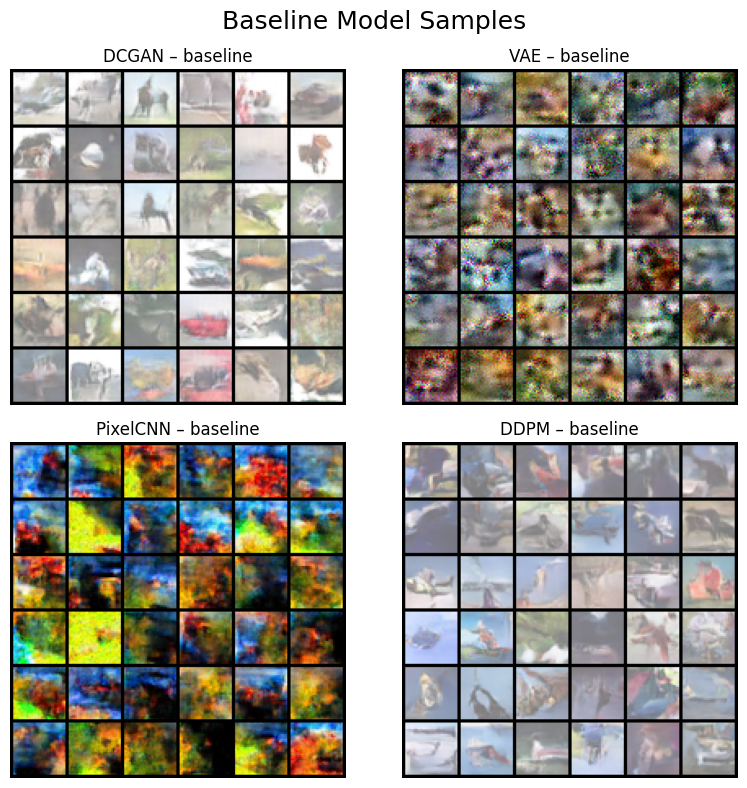

In [ ]:
# 2. Baseline training and qualitative inspection : A 6 × 6 generated image sample grid for each mode

baseline_images = [
    ("dcgan_samples_baseline_6x6.png",   "DCGAN – baseline"),
    ("vae_samples_baseline_6x6.png",     "VAE – baseline"),
    ("pixelcnn_samples_baseline_6x6.png","PixelCNN – baseline"),
    ("ddpm_samples_baseline_6x6.png",    "DDPM – baseline"),
]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, (fname, title) in zip(axes.flat, baseline_images):
    img_path = ARTIFACT_DIR / fname
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

fig.suptitle("Baseline Model Samples", fontsize=18)

plt.tight_layout()
plt.show()


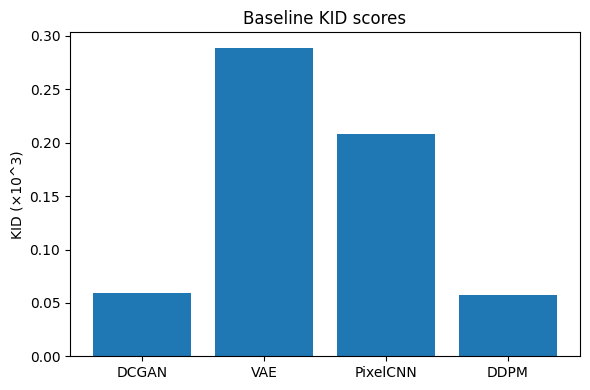

In [ ]:
# 2. Baseline training and qualitative inspection: Kernel Inception Distance (KID) against the CIFAR-10 validation split

summary = json.load(open(ARTIFACT_DIR / "metrics_summary.json"))

rows = []
for model_name, variants in summary.items():
    if "baseline" in variants:
        rows.append(
            {
              "model": model_name,
              "kid": variants["baseline"]["kid"]
        }
        )

df = pd.DataFrame(rows)

plt.figure(figsize=(6,4))
plt.bar(df["model"], df["kid"])
plt.ylabel("KID (×10^3)")
plt.title("Baseline KID scores")
plt.tight_layout()
plt.show()


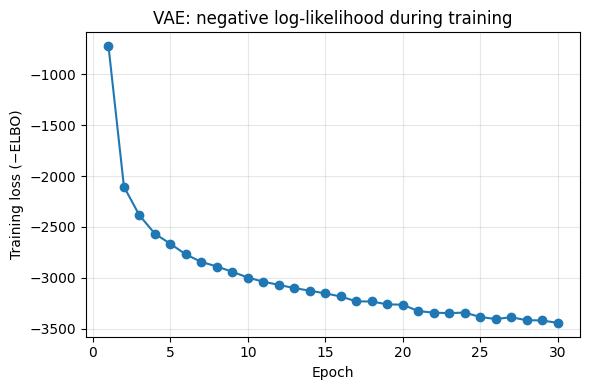

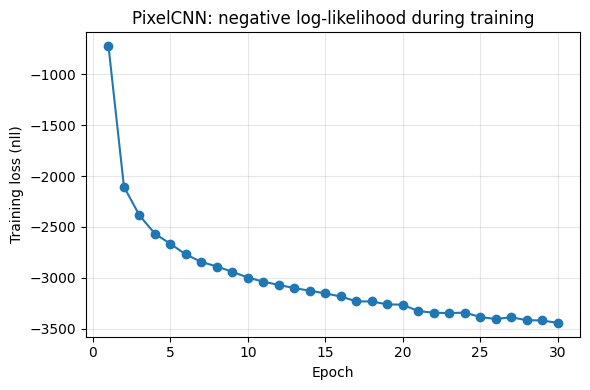

In [ ]:
# 2. Baseline training and qualitative inspection:For PixelCNN and VAE, provide the plot of negative log-likelihood estimates during training

def load_history(name):
    path = ARTIFACT_DIR / f"{name}_history.json"
    with path.open() as f:
        history = json.load(f)
    return history

def loss_per_epoch(history, epochs):
    losses = np.array(history["loss"], dtype=float)
    steps_per_epoch = losses.size // epochs
    losses = losses[:epochs * steps_per_epoch].reshape(epochs, steps_per_epoch)
    return losses.mean(axis=1)

vae_history = load_history("vae_baseline_history")
pixelcnn_history = load_history("pixelcnn_baseline_history")

n_epochs = 30

vae_epoch_loss = loss_per_epoch(vae_history, n_epochs)
pixelcnn_epoch_loss = loss_per_epoch(pixelcnn_history, n_epochs)

# VAE: negative ELBO / NLL estimate ----
plt.figure(figsize=(6, 4))
plt.plot(range(1, n_epochs + 1), vae_epoch_loss, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training loss (−ELBO)")
plt.title("VAE: negative log-likelihood during training")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---- PixelCNN: NLL ----
plt.figure(figsize=(6, 4))
plt.plot(range(1, n_epochs + 1), pixelcnn_epoch_loss, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training loss (nll)")
plt.title("PixelCNN: negative log-likelihood during training")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



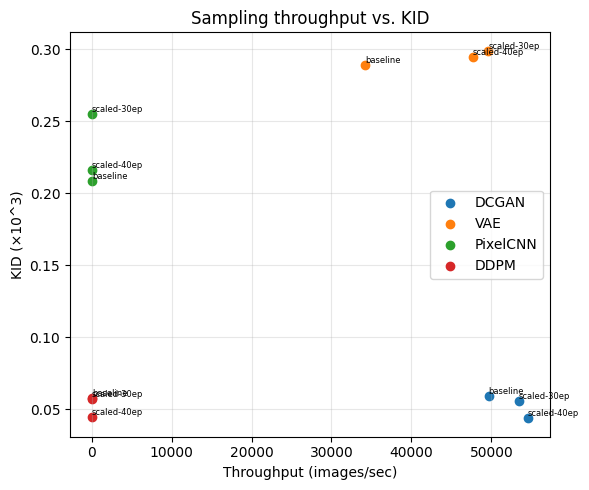

In [ ]:
# 3. Sampling behaviour and efficiency: Throughput vs KID

metrics_path = ARTIFACT_DIR / "metrics_summary.json"

with metrics_path.open() as f:
    metrics = json.load(f)

rows = []
for model_name, variants in metrics.items():
    for variant, m in variants.items():
        rows.append(
            {
              "model": model_name,
              "variant": variant,
              "throughput": m["throughput_img_per_s"],
              "kid": m["kid"]
            }
        )

df = pd.DataFrame(rows)
# display(df)

plt.figure(figsize=(6, 5))
for model in df["model"].unique():
    sub = df[df["model"] == model]
    plt.scatter(sub["throughput"], sub["kid"], label=model)
    for i, row in sub.iterrows():
        plt.text(
            row["throughput"],
            row["kid"],
            row["variant"],
            fontsize=6,
            ha="left",
            va="bottom",
        )

plt.xlabel("Throughput (images/sec)")
plt.ylabel("KID (×10^3)")
plt.title("Sampling throughput vs. KID")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()




      model      variant  time_per_epoch          nll
0       VAE     baseline        3.206806 -3560.793197
1       VAE  scaled-30ep        3.251125 -3592.716391
2       VAE  scaled-40ep        3.250039 -3745.476532
3  PixelCNN     baseline        6.826203     3.696473
4  PixelCNN  scaled-30ep        9.945962     3.628127
5  PixelCNN  scaled-40ep        9.937272     3.557467


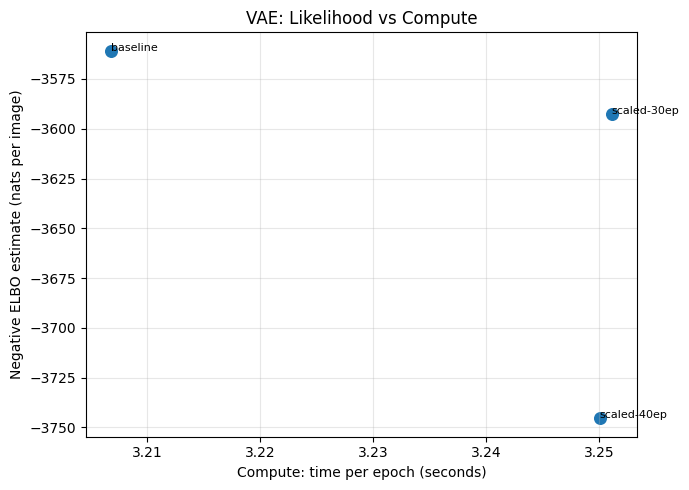

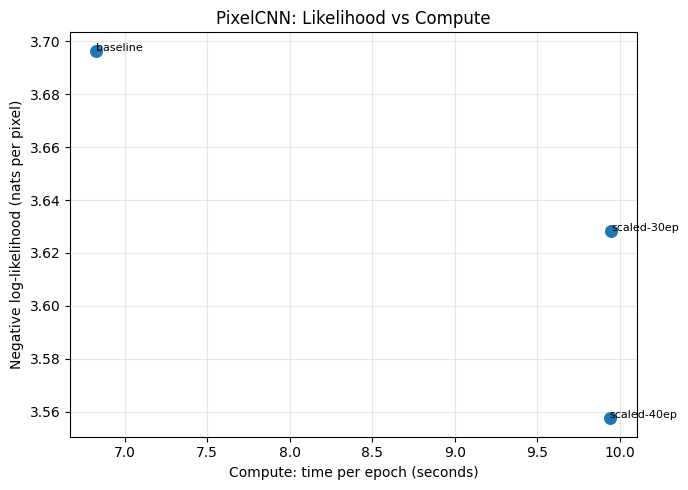

In [8]:
# 4. Likelihood versus compute (VAE and PixelCNN): Plot of compute (time per epoch)
# versus negative log-likelihood, and explain any differences.

# I forgot to save all the ouputs from evaluate_vae_elbo so i took it from the prints
# VAE baseline: Validation ELBO: -3560.7932 (recon -3795.2261, KL 234.4329)
# VAE medium 30 ep: Validation ELBO: -3592.7164 (recon -3853.5190, KL 260.8026)
# VAE medium 40 ep: Validation ELBO: -3745.4765 (recon -4016.3151, KL 270.8385)
# PixelCNN baseline: Validation NLL: 3.6965
# PixelCNN 30 ep: Validation NLL: 3.6281
# PixelCNN 40 ep: Validation NLL: 3.5575

import json
import pandas 
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
summary = json.load(open(ARTIFACT_DIR / "metrics_summary.json"))

vae_ll = {
    "baseline":   3560.7932,
    "scaled-30ep":   3592.7164,
    "scaled-40ep":   3745.4765,
}

pixelcnn_ll = {
    "baseline":   3.6965,
    "scaled-30ep":   3.6281,
    "scaled-40ep":   3.5575,
}

rows = []

#vae
for variant, nll in vae_ll.items():
    t = summary["VAE"][variant]["train_time_per_epoch_s"]
    nll = summary["VAE"][variant]["nll"]
    rows.append(("VAE", variant, t, nll))
#pixelcnn
for variant, nll in pixelcnn_ll.items():
    t = summary["PixelCNN"][variant]["train_time_per_epoch_s"]
    nll = summary["PixelCNN"][variant]["nll"]
    rows.append(("PixelCNN", variant, t, nll))

df = pd.DataFrame(rows, columns=["model", "variant", "time_per_epoch", "nll"])
print(df)


plt.figure(figsize=(7, 5))
sub = df[df["model"] == "VAE"]

plt.scatter(sub["time_per_epoch"], sub["nll"], s=70)

for _, row in sub.iterrows():
    plt.text(
        row["time_per_epoch"],
        row["nll"],
        row["variant"],
        fontsize=8
    )

plt.xlabel("Compute: time per epoch (seconds)")
plt.ylabel("Negative ELBO estimate (nats per image)")
plt.title("VAE: Likelihood vs Compute")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(7, 5))
sub = df[df["model"] == "PixelCNN"]

plt.scatter(sub["time_per_epoch"], sub["nll"], s=70)

for _, row in sub.iterrows():
    plt.text(
        row["time_per_epoch"],
        row["nll"],
        row["variant"],
        fontsize=8
    )

plt.xlabel("Compute: time per epoch (seconds)")
plt.ylabel("Negative log-likelihood (nats per pixel)")
plt.title("PixelCNN: Likelihood vs Compute")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [112]:
# 5. Parameter scaling study

rows = []
for model, variants in summary.items():
    for variant, data in variants.items():
        rows.append({
            "model": model,
            "variant": variant,
            "epochs": data["epochs"],
            "params": data["params"],
            "KID": data["kid"],
            "NLL": data.get("nll", None),  # Only VAE + PixelCNN have NLL
            "train_time_per_epoch": data["train_time_per_epoch_s"],
            "throughput_img_per_s": data["throughput_img_per_s"],
            "sampling_time_s": data["sampling_time_s"]
        })

df = pd.DataFrame(rows)
df = df.sort_values(["model", "variant"])
# print(df)

def df_to_latex(df, caption=None, label=None):
    return df.to_latex(
        index=False,
        float_format="%.4f",
        caption=caption,
        label=label,
        escape=False,
    )


def capacity_table(df):
    # baseline (small) vs scaled-30ep (medium, 30 epochs)
    sub = df[df["variant"].isin(["baseline", "scaled-30ep"])].copy()
    sub = sub.sort_values(["model", "variant"])

    name_map = {
        "baseline": "small-30ep",
        "scaled-30ep": "medium-30ep",
    }
    sub["variant"] = sub["variant"].map(name_map)

    # choose the columns you want in the report
    cols = [
        "model",
        "variant",
        "KID",
        "params",
        "train_time_per_epoch",
        "throughput_img_per_s",
        "sampling_time_s",
    ]
    sub = sub[cols].copy()

    return df_to_latex(
        sub,
        caption="Capacity effect. Small vs medium for 30 epochs.",
        label="tab:capacity_30ep",
    )

print(capacity_table(df))

def capacity_table_vae_pixelcnn(df):
    # baseline (small) vs scaled-30ep for vae and pixelcnn (medium, 30 epochs)
    sub = df[df["variant"].isin(["baseline", "scaled-30ep"])].copy()
    sub = sub[sub["model"].isin(["VAE", "PixelCNN"])].copy()
    sub = sub.sort_values(["model", "variant"])

    name_map = {
        "baseline": "small-30ep",
        "scaled-30ep": "medium-30ep",
    }
    sub["variant"] = sub["variant"].map(name_map)

    # choose the columns you want in the report
    cols = [
        "model",
        "variant",
        "NLL"
    ]
    sub = sub[cols].copy()

    return df_to_latex(
        sub,
        caption="Capacity effect VAE and PixelCNN. Small vs medium for 30 epochs.",
        label="tab:capacity_30ep_nll",
    )

print(capacity_table_vae_pixelcnn(df))


def compute_table(df):
    # medium 30 vs 40 epochs
    sub = df[df["variant"].isin(["scaled-30ep", "scaled-40ep"])].copy()
    sub = sub.sort_values(["model", "variant"])

    name_map = {
        "scaled-30ep": "medium-30ep",
        "scaled-40ep": "medium-40ep",
    }
    sub["variant"] = sub["variant"].map(name_map)

    cols = [
        "model",
        "variant",
        "KID",
        "params",
        "train_time_per_epoch",
        "throughput_img_per_s",
        "sampling_time_s",
    ]
    sub = sub[cols]

    return df_to_latex(
        sub,
        caption="Compute effect. Medium 30 vs 40 epochs.",
        label="tab:compute_30vs40",
    )

print(compute_table(df))

def compute_table_vae_pixelcnn(df):
    # medium 30 vs 40 epochs
    sub = df[df["variant"].isin(["scaled-30ep", "scaled-40ep"])].copy()
    sub = sub[sub["model"].isin(["VAE", "PixelCNN"])].copy()
    sub = sub.sort_values(["model", "variant"])

    name_map = {
        "scaled-30ep": "medium-30ep",
        "scaled-40ep": "medium-40ep",
    }
    sub["variant"] = sub["variant"].map(name_map)

    cols = [
        "model",
        "variant",
        "NLL",
    ]
    sub = sub[cols]

    return df_to_latex(
        sub,
        caption="Compute effect VAE and PixelCNN. Medium 30 vs 40 epochs.",
        label="tab:compute_30vs40_vae_pixelcnn",
    )

print(compute_table_vae_pixelcnn(df))



\begin{table}
\caption{Capacity effect. Small vs medium for 30 epochs.}
\label{tab:capacity_30ep}
\begin{tabular}{llrrrrr}
\toprule
model & variant & KID & params & train_time_per_epoch & throughput_img_per_s & sampling_time_s \\
\midrule
DCGAN & small-30ep & 0.0593 & 1846980 & 4.9887 & 49664.0740 & 0.0206 \\
DCGAN & medium-30ep & 0.0559 & 3753508 & 5.1776 & 53438.9030 & 0.0192 \\
DDPM & small-30ep & 0.0575 & 6993987 & 12.2572 & 18.3291 & 55.8676 \\
DDPM & medium-30ep & 0.0568 & 14747107 & 17.6171 & 14.3093 & 71.5621 \\
PixelCNN & small-30ep & 0.2083 & 268992 & 6.8262 & 33.8358 & 30.2638 \\
PixelCNN & medium-30ep & 0.2549 & 744480 & 9.9460 & 20.0902 & 50.9701 \\
VAE & small-30ep & 0.2890 & 3518214 & 3.2068 & 34186.3666 & 0.0300 \\
VAE & medium-30ep & 0.2989 & 7906950 & 3.2511 & 49605.0657 & 0.0206 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Capacity effect VAE and PixelCNN. Small vs medium for 30 epochs.}
\label{tab:capacity_30ep_nll}
\begin{tabular}{llr}
\toprule
